In [133]:
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsbombpy import sb
import pandas as pd
from PIL import Image
import seaborn as sns

from mplsoccer import Pitch, VerticalPitch

In [175]:
df = sb.events(match_id=3754290).sort_values(by='index')
team1 = df[df['team'] == 'Manchester City']
team2 = df[df['team'] == 'Leicester City']
team1.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 442, 'lineup': [{'player': {'id'...",Manchester City,36,00:00:00.000,Starting XI,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Manchester City,36,00:00:00.000,Half Start,NaN
2578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Manchester City,36,00:00:01.266,Pressure,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Manchester City,36,00:00:16.913,Pass,NaN
959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Manchester City,36,00:00:17.896,Ball Receipt*,True


In [135]:
def createShotMap(team, ax):
    #pitch = Pitch
    pitch = VerticalPitch(pitch_color='#aabb97', line_color='white',
    stripe_color='#c2d59d', half=True, stripe=True)  # optional stripes

    # specifying figure size (width, height)
    pitch.draw(ax=ax)

    shots = team[team['type'] == 'Shot']
    shots = shots[['team', 'player', 'location', 'shot_type', 'shot_outcome', 'shot_statsbomb_xg', 'timestamp']]
    shots[['x', 'y']] = shots['location'].apply(pd.Series)

    shots

    for shot in shots.to_dict(orient='records'): #convert to list and iterate through
        pitch.scatter(x = shot['x'], y = shot['y'], ax=ax,
                        c='green' if shot['shot_outcome'] == 'Goal' else 'white',
                    edgecolors='black', linewidths= 0.8, s=(800 * shot['shot_statsbomb_xg']))


In [136]:
def create_table(team1, team2):
    # Drop rows where the pass_outcome is Unknown
    team1 = team1[team1['pass_outcome'] != 'Unknown']
    team2 = team2[team2['pass_outcome'] != 'Unknown']
    
    # Create a table with the data
    # We first need to calculate the statistics for each team
    # we will calcualte the following stats:
    # - goals
    # - xG
    # - shots
    # - shots on target
    # - passes
    # - pass completion %
    
    # Create a dictionary to store the stats
    stats = {
        'goals': {'team1': len(team1[team1['type'] == 'Goal']), 'team2': len(team2[team2['type'] == 'Goal'])},
        'xG': {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
        'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
        'shots_on_target': {
            'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
            'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
        },
        'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
        'pass_completion': {
            'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
            'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)
        }
    }
    
    # store as a dataframe
    stats_df = pd.DataFrame(stats).T

    column_labels = ['', '', '']
    table_vals = [
        [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
        [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
        [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
        [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
        [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
    ]
    
    return column_labels, table_vals

In [137]:
def create_passnetwork(team, ax):
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    tactics = team[~team['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
        
    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
    
    # Make a new, single column for time and sort the events in chronological order
    team["newsecond"] = 60 * team["minute"] + team["second"]
    
    team.sort_values(by=['newsecond'])
    
    # identify the passer and then the recipient, who'll be the playerId of the next action
    team['passer'] = team['player_id']
    
    team['recipient'] = team['passer'].shift(-1)
    
    # filter for only passes and then successful passes
    passes_df = team.loc[(team['type']=="Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
    
    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
    
    #find time of the team's first substitution and filter the df to only passes before that
    sub_df = team.loc[(team['type'] == "Substitution")]
    first_sub = sub_df["newsecond"].min()
    
    if first_sub <= (60 * 45):
        first_sub = 60 * 45
    
    completions = completions.loc[completions['newsecond'] < first_sub]
    
    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
    average_locs_and_count.columns = ['x', 'y', 'count']
    
    # find number of passes along each 'path' of passer to recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )
    
    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
    # plot arrows
    def pass_line_template(ax, x, y, end_x, end_y, line_color):
        ax.annotate(
            '',
            xy=(end_y,  end_x),
            xytext=(y, x),
            zorder=1,
            arrowprops=dict(arrowstyle='-|>', linewidth=2, color=line_color, alpha=.85)
        )
        
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y-y, end_x-x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#aabb97', line_color='white',
    stripe_color='#c2d59d', stripe=True)
    pitch.draw(ax=ax)
    
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
    
    # plot nodes
    pitch.scatter(
        average_locs_and_count.x, average_locs_and_count.y, s=500,
        color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
    )
    
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(
            jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
            xy=(row.x, row.y),
            c='#132743',
            va='center',
            ha='center',
            size=10,
            ax=ax
        )

C:\Users\tomas.hehir\AppData\Local\Temp\ipykernel_25848\4020726984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team[['x', 'y']] = team['location'].apply(pd.Series)
C:\Users\tomas.hehir\AppData\Local\Temp\ipykernel_25848\4020726984.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team["newsecond"] = 60 * team["minute"] + team["second"]
C:\Users\tomas.hehir\AppData\Local\Temp\ipykernel_25848\4020726984.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

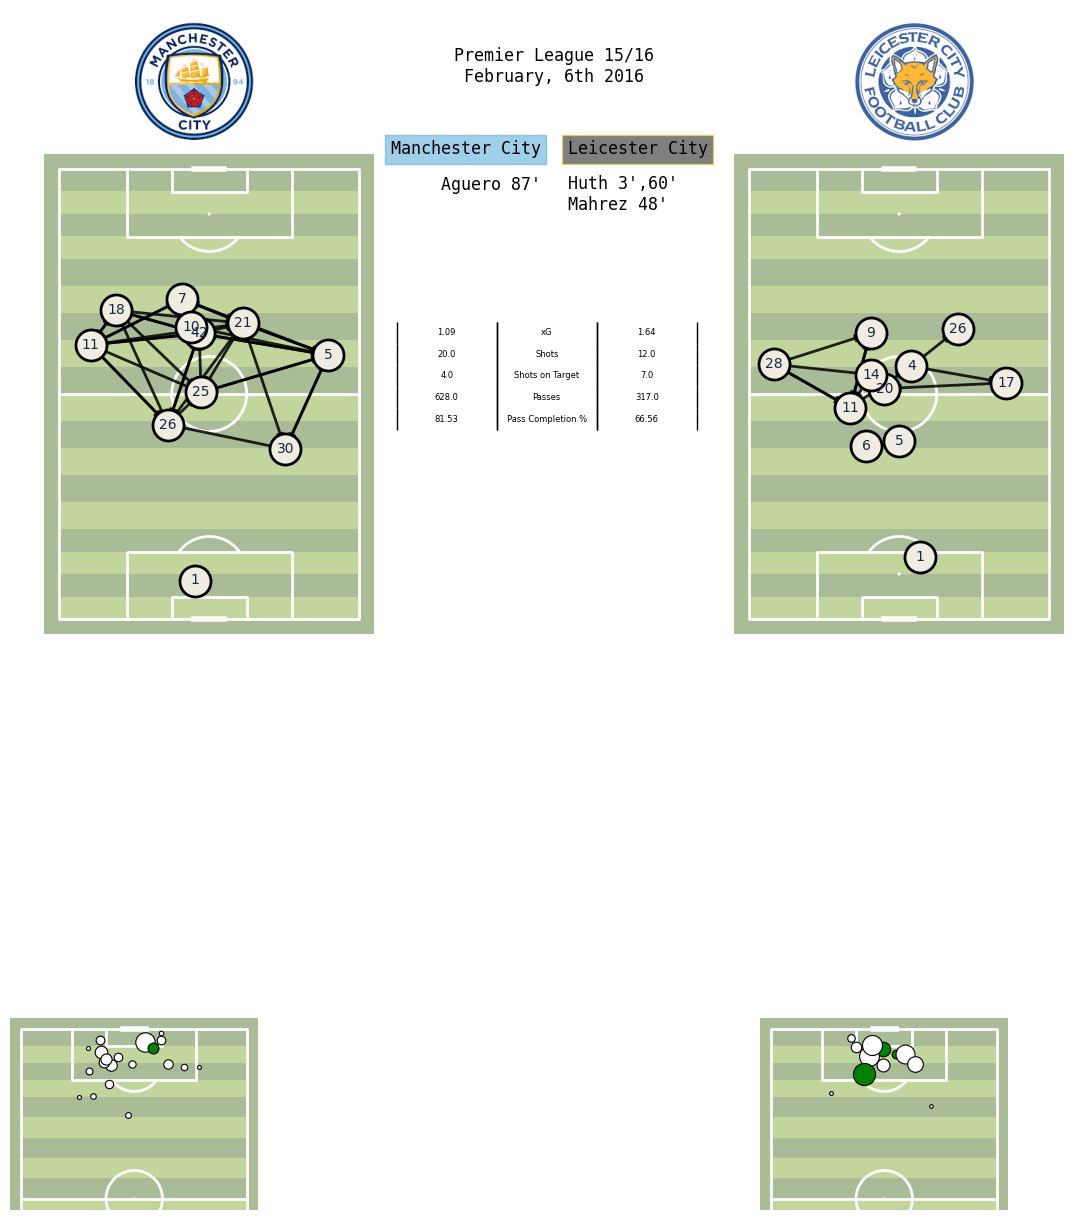

In [101]:
fig = plt.figure(figsize=(15, 12))

axMatch = fig.add_axes([0.43, 0.8, 0.3, 0.3])
axMatch.text(0.5, 0.8, 'Premier League 15/16\nFebruary, 6th 2016', fontsize=12, ha='center', fontdict={'family': 'monospace'})

team1_text = axMatch.text(0.47, 0.6, 'Manchester City', fontsize=12, ha='right', fontdict={'family': 'monospace'})
team1_text.set_bbox(dict(facecolor='#43A1D5', alpha=0.5, edgecolor='#43A1D5'))
axMatch.text(0.47, 0.5, 'Aguero 87\'', fontsize=12, ha='right', fontdict={'family': 'monospace'})

team2_text = axMatch.text(0.53, 0.6, 'Leicester City', fontsize=12, ha='left', fontdict={'family': 'monospace'})
team2_text.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='gold'))
axMatch.text(0.53, 0.445, 'Huth 3\',60\' \nMahrez 48\'', fontsize=12, ha='left', fontdict={'family': 'monospace'})
axMatch.axis('off')

axstattable1 = fig.add_axes([0.475,0.65,0.2,0.2])
column_labels, table_vals = create_table(team1, team2)

table = axstattable1.table(
    cellText=table_vals, 
    cellLoc='center', 
    edges='vertical',
    bbox=[0, .5, 1, .45],
)

axstattable1.axis('off')

axCrest1 = fig.add_axes([0.24, 0.99, 0.2, 0.1])
crest1_img = Image.open('C:/Users/tomas.hehir/Source/Repos/Footy/images/mancity.png')
axCrest1.imshow(crest1_img)
axCrest1.axis('off')

axCrest2 = fig.add_axes([0.72, 0.99, 0.2, 0.1])
crest2_img = Image.open('C:/Users/tomas.hehir/Source/Repos/Footy/images/leicestercity.png')
axCrest2.imshow(crest2_img)
axCrest2.axis('off')


axpass1 = fig.add_axes([0.15,0.58,0.4,0.4])
create_passnetwork(team1, axpass1)

axpass2 = fig.add_axes([0.61,0.58,0.4,0.4])
create_passnetwork(team2, axpass2)

axshot1 = fig.add_axes([0.2,0.1,0.2,0.16])
createShotMap(team1, axshot1)

axshot2 = fig.add_axes([0.7,0.1,0.2,0.16])
createShotMap(team2, axshot2)